In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import pytz

from meteocre.fetchhrrr import HRRRProduct
from meteocre.fetchhrrr.visualize.nws_standard_colormaps import cm_dpt

2022-10-05 23:44:18,204 INFO [hrrr_product] Downloading HRRR product from URL: https://storage.googleapis.com/high-resolution-rapid-refresh/hrrr.20180501/conus/hrrr.t18z.wrfsfcf06.grib2
2022-10-05 23:44:18,205 INFO [hrrr_product] File already exists! Re-using.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2269P x 976L.
0...10...20...30...40...50...60...70...80...90...100 - done.


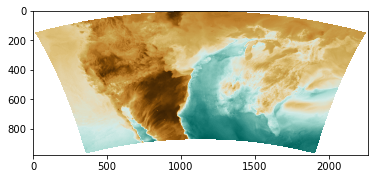

In [4]:
run_time = datetime(2018, 5, 1, 18, 0, 0).replace(tzinfo=pytz.UTC)
forecast_hour = 6
product_id = 'sfc'

product = HRRRProduct.from_archive(run_time, forecast_hour, product_id)

ds = product.get_ds_for_product_idx([57])
im = ds.GetRasterBand(1).ReadAsArray()
plt.imshow(im, **cm_dpt())
plt.show()